In [1]:
import numpy as np
from utils.model import truncateModel, getLayerDict
from utils.optimization import getIterateFunction, gradientAscent
import matplotlib.pyplot as plt
import time
from scipy import signal
import IPython.display as ipd
import librosa
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [6]:
 #We load the trained VGG model
pathToModel = "model/model_VGG16_11_12_2018.h5"

model = model_from_json(open("model/architecture_msdTag.json").read())
model.load_weights("model/weight_msdTag.hdf5")

layerDict = getLayerDict(model)
model.summary()

/home/badrdr/.conda/envs/tf/lib/python3.6/site-packages/keras/engine/base_layer.py:1109: UserWarning: Update your `InputLayer` call to the Keras 2 API: `InputLayer(batch_input_shape=[None, 590..., sparse=False, name="input_1", dtype="float32")`
  return cls(**config)
/home/badrdr/.conda/envs/tf/lib/python3.6/site-packages/keras/engine/base_layer.py:1109: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(name="convolution1d_1", activity_regularizer=None, trainable=True, activation="linear", input_shape=(None, Non..., filters=128, kernel_size=3, strides=3, padding="valid", kernel_initializer="he_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
/home/badrdr/.conda/envs/tf/lib/python3.6/site-packages/keras/engine/base_layer.py:1109: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(gamma_regularizer=None, name="batchnormalization_1", epsilo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59049, 1)          0         
_________________________________________________________________
convolution1d_1 (Conv1D)     (None, 19683, 128)        512       
_________________________________________________________________
batchnormalization_1 (BatchN (None, 19683, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 19683, 128)        0         
_________________________________________________________________
convolution1d_2 (Conv1D)     (None, 19683, 128)        49280     
_________________________________________________________________
batchnormalization_2 (BatchN (None, 19683, 128)        512       
_________________________________________________________________
activation_2 (Activation)    (None, 19683, 128)        0         
__________

In [7]:
sampleAu,fs = librosa.load("audio/rock.00001.au")

ipd.Audio(sampleAu, rate=fs)

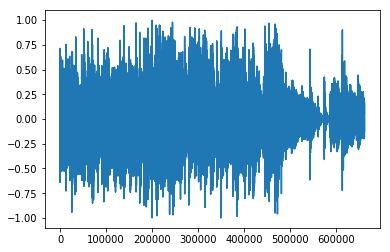

In [8]:
plt.plot(sampleAu)

In [9]:
#Corresponds to the size of the training mel spectrogram
    
signalLength = 59049

In [10]:
keptFilters = []
    
inputTensor = model.input
layerName = 'activation_3'

print("Percentage : ")
for filterIndex in range(128):
    print('-{}'.format(filterIndex/128*100))
    startTime = time.time()

    iterate = getIterateFunction(layerDict, layerName, filterIndex, inputTensor)
    
    #inputImgData = (np.random.random((1, imgWidth, imgHeight, 3)) - 0.5) * 20 + 128
    inputImgData = sampleAu[np.newaxis,:signalLength,np.newaxis].copy()
    
    step = 0.1

    lossValue = gradientAscent(iterate, inputImgData, step)

    print('Current loss value:', lossValue)

    if lossValue > 0.:
        print("kept!")
        keptFilters.append((inputImgData[0,:,0], lossValue))
        if len(keptFilters) == 5:
            break
    endTime = time.time()
    #print('Filter %d processed in %ds' % (filterIndex, endTime - startTime))

Percentage : 
-0.0
Current loss value: 86.579285
kept!
-0.78125
Current loss value: 387.09045
kept!
-1.5625
Current loss value: 5.637292
kept!
-2.34375
Current loss value: 125.59083
kept!
-3.125
Current loss value: 59.749737
kept!


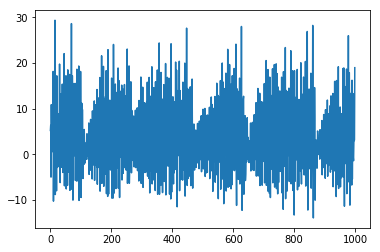

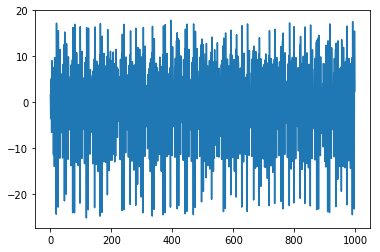

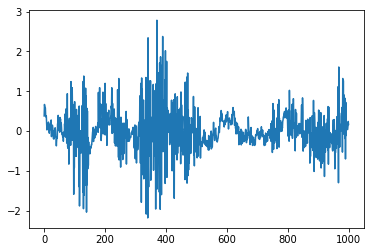

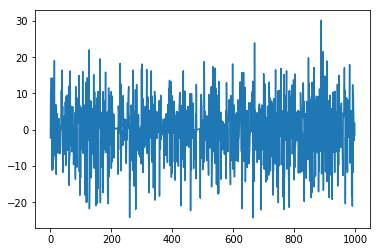

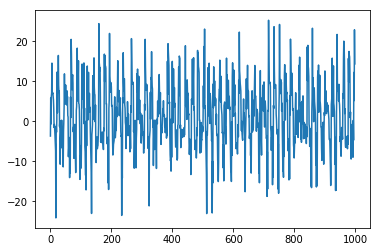

In [27]:
for img in keptFilters:
    plt.figure()
    plt.plot(range(1000),img[0][:1000])

In [29]:
for i in range(len(keptFilters)):
    #rever = signal.istft(keptFilters[i][0], fs=22050, nperseg=198)
    ipd.display(ipd.Audio(keptFilters[i][0], rate=22050))

In [ ]:
model.predict(sampleAu[:signalLength])